In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_2336351/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"


In [4]:
import torch
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches
from scipy.stats import spearmanr
from sklearn.cross_decomposition import CCA
from sklearn import datasets
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import mantel
from sknetwork.clustering import Louvain
from sklearn.cluster import DBSCAN
import harmonypy as hm
from harmony import harmonize

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import label_dict
from label_dict import protein_to_num_single_cells, protein_to_num_full
from label_dict import hierarchical_organization_single_cell_low_level, hierarchical_organization_single_cell_high_level
from label_dict import hierarchical_organization_whole_image_low_level, hierarchical_organization_whole_image_high_level
from tqdm import tqdm
from scipy.stats import ttest_ind, zscore, norm
from statsmodels.stats.weightstats import ztest as ztest
from skimage import io
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, cdist
from seaborn import clustermap
from scipy.spatial.distance import squareform
import cuml
from sklearn.metrics import average_precision_score

cmap = cm.nipy_spectral


In [9]:
import matplotlib
font = {'size'   : 5}
matplotlib.rc('font', **font)

def scale(features, features_mean=None, features_std=None):
    if features_mean is None:
        features_mean = features.mean(axis=0)
    if features_std is None:
        features_std = features.std(axis=0)
    transformed_features = (features - features_mean) / (features_std + 0.00001)
    return transformed_features, features_mean, features_std


def get_gene_heterogeneity_enrichement(config_files, heterogenous_type='HPA_variable', condition=None, use_embedding=False):
    enrichments_conditioned_on_gene = []
    enrichments_conditioned_on_image = []
    genes_sorted_conditioned_on_image = []
    genes_sorted_conditioned_on_gene = []
    merged_dfs = []
    sorted_metrics_conditioned_on_image = []
    sorted_metrics_conditioned_on_gene = []
    images_sorted_conditioned_on_image = []
    average_precisions_condition_on_gene = []
    average_precisions_condition_on_image = []
    for config_file in config_files:
        enrichment, merged_df, genes_sorted, _, sorted_metric_conditioned_on_gene, _ = find_gene_enrichment(config_file, heterogenous_type = heterogenous_type, condition=condition, use_embedding=use_embedding, granularity='gene')
        sorted_metrics_conditioned_on_gene.append(sorted_metric_conditioned_on_gene)
        genes_sorted_conditioned_on_gene.append(genes_sorted)
        enrichments_conditioned_on_gene.append(enrichment)
        gene_ground_truth = pd.merge(pd.DataFrame(genes_sorted, columns=['Gene']), merged_df[['Gene','HPA_variable']].drop_duplicates(), on='Gene')['HPA_variable'].apply(lambda x:pd.isnull(x) == False).astype(int).values
        gene_predictions = np.where(np.isnan(sorted_metric_conditioned_on_gene), 0, sorted_metric_conditioned_on_gene)
        average_precisions_condition_on_gene.append(average_precision_score(gene_ground_truth, gene_predictions))

        enrichment, merged_df, genes_sorted, images_sorted, sorted_metric_conditioned_on_gene, sorted_metric_conditioned_on_image = find_gene_enrichment(config_file, heterogenous_type = heterogenous_type, condition=condition, use_embedding=use_embedding, granularity='image')
        sorted_metrics_conditioned_on_image.append(sorted_metric_conditioned_on_gene)
        genes_sorted_conditioned_on_image.append(genes_sorted)
        enrichments_conditioned_on_image.append(enrichment)
        gene_ground_truth = pd.merge(pd.DataFrame(genes_sorted, columns=['Gene']), merged_df[['Gene','HPA_variable']].drop_duplicates(), on='Gene')['HPA_variable'].apply(lambda x:pd.isnull(x) == False).astype(int).values
        gene_predictions = np.where(np.isnan(sorted_metric_conditioned_on_gene), 0, sorted_metric_conditioned_on_gene)
        average_precisions_condition_on_image.append(average_precision_score(gene_ground_truth, gene_predictions))

        merged_dfs.append(merged_df)
        images_sorted_conditioned_on_image.append(images_sorted)
    return (enrichments_conditioned_on_gene, enrichments_conditioned_on_image, merged_dfs, genes_sorted_conditioned_on_gene, genes_sorted_conditioned_on_image, sorted_metrics_conditioned_on_gene, sorted_metrics_conditioned_on_image, images_sorted_conditioned_on_image, average_precisions_condition_on_gene, average_precisions_condition_on_image)

def plot_gene_heterogeneity_enrichement(labels, enrichments, enrichments_image, heterogenous_type):
    colors = ['#529de5','#d32c23','#55c87b',]
    if len(enrichments) > 0:
        fig, ax = plt.subplots(1,1,figsize=(2.5,2.5), facecolor='white', dpi=300)
        for ind, label in enumerate(labels):
#             plt.plot(enrichments[ind], label=label)
            plt.plot(enrichments[ind][10:510], label=label, color=colors[ind])
        plt.legend(frameon=False)
        ax.set_xlabel('Number of genes, sorted by feature variance')
        ax.set_ylabel('Percentage of ground truth heterogeneous genes')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xticks(range(0, 501, 100), range(10, 511, 100))
        print('')
        plt.title(f'Heterogeneous gene ranking ({heterogenous_type})')
    if len(enrichments_image) > 0:
        fig, ax = plt.subplots(1,1,figsize=(2.5,2.5), facecolor='white', dpi=300)
        for ind, label in enumerate(labels):
#             plt.plot(enrichments_image[ind], label=label)
            plt.plot(enrichments_image[ind][10:510], label=label, color=colors[ind])
        plt.legend(frameon=False)
        ax.set_xlabel('Number of genes, sorted by image heterogeneity')
        ax.set_ylabel('Percentage of ground truth heterogeneous genes')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.xticks(range(0, 501, 100), range(10, 511, 100))
        print('')
        plt.title(f'Heterogeneous gene ranking ({heterogenous_type})')



def get_heirarchical_clustering(df, features, labels, zero_diagonal=True, metric='similarity'):
    averaged_features, columns = get_averaged_features(df, features, labels)
    if metric == 'similarity':
        distance_matrix = cosine_similarity(averaged_features, averaged_features)
    else:
        distance_matrix = cosine_distances(averaged_features, averaged_features)
        
    Z = linkage(distance_matrix)
    plt.figure(figsize=(20,5))
    dn = dendrogram(Z, labels = columns)
    plt.xticks(rotation=45)
    distance_matrix = distance_matrix[dn['leaves'], :][:, dn['leaves']]
    columns = dn['ivl']
    plt.figure(figsize=(10,10))
    if zero_diagonal:
        for i in range(len(distance_matrix)):
            distance_matrix[i,i] = 0
    plt.imshow(distance_matrix)
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    return distance_matrix, columns, Z

def get_heterogeneousity_per_whole_image(df, features, indices, metric='distance', verbose=False):
    cells_per_ID = df.iloc[indices].groupby('ID').groups
    mean_distances_per_ID = []
    for ID in tqdm(sorted(cells_per_ID.keys()), disable=verbose == False):
        if metric == 'distance':
            distance_matrix = cosine_distances(features[cells_per_ID[ID]], 
                                                features[cells_per_ID[ID]])
            distances = np.triu(distance_matrix)[np.triu_indices(distance_matrix.shape[0], k=1)]
            if len(distances) == 0: continue
            mean_distances_per_ID.append(distances.mean())
        elif metric == 'std':
            mean_distances_per_ID.append(features[cells_per_ID[ID]].std(axis=0).mean().item())
    return mean_distances_per_ID, sorted(cells_per_ID.keys())

def get_heterogeneousity_per_gene(merged_df, features, indices, metric='distance', verbose=False):
    cells_per_gene = merged_df.iloc[indices].groupby(['Gene']).groups
    keys = sorted(cells_per_gene.keys())
    mean_distances_per_ID = []
    for gene in tqdm(keys):
        if metric == 'distance':
            distance_matrix = cosine_distances(features[cells_per_gene[gene]], 
                                                features[cells_per_gene[gene]])
            distances = np.triu(distance_matrix)[np.triu_indices(distance_matrix.shape[0], k=1)]
            if len(distances) == 0: continue
            mean_distances_per_ID.append(distances.mean())
        elif metric == 'std':
            mean_distances_per_ID.append(features[cells_per_gene[gene]].std(axis=0).mean().item())
    return mean_distances_per_ID, keys

def get_heterogeneity_df(config_file):
    config = yaml.safe_load(open(config_file, "r"))
    df = pd.read_csv(config['embedding']['df_path'])
    df_master = pd.read_csv('/scr/mdoron/Dino4Cells/Master_scKaggle.csv')
    df = pd.merge(df, df_master[['ID','gene']], on='ID')
    df['Gene'] = df['gene']
    proto_heterogeneity_df = pd.read_csv('/scr/mdoron/Dino4Cells/data/gene_heterogeneity.tsv', delimiter='\t')
    proto_heterogeneity_df['v_spatial'] = proto_heterogeneity_df['Single-cell variation spatial']
    proto_heterogeneity_df['v_intensity'] = proto_heterogeneity_df['Single-cell variation intensity']
    proto_heterogeneity_df['HPA_variable'] = np.nan
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_intensity']) == False),'v_intensity'] = True
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_intensity'])),'v_intensity'] = False
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_spatial']) == False),'v_spatial'] = True
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_spatial'])),'v_spatial'] = False
    proto_heterogeneity_df.loc[(proto_heterogeneity_df['v_spatial']) | (proto_heterogeneity_df['v_intensity']), 'HPA_variable'] = True
    heterogeneity_df = pd.merge(proto_heterogeneity_df, df, on='Gene')[['Gene','ID','v_spatial','v_intensity','HPA_variable', 'cell_type']]
    return heterogeneity_df

def find_gene_enrichment(config_file, heterogenous_type = 'HPA_variable', granularity='gene', condition = None, use_embedding=False):
    config = yaml.safe_load(open(config_file, "r"))
    df = pd.read_csv(config['embedding']['df_path'])    
    heterogeneity_df = get_heterogeneity_df(config_file)
    merged_df = pd.merge(heterogeneity_df, df, on='ID', how='right').drop_duplicates()
    merged_df.loc[pd.isnull(merged_df['Gene']),'Gene'] = ''
    merged_df = merged_df.reset_index()
    merged_df['original_index'] = merged_df.index.values
    merged_df['cell_type'] = merged_df.cell_type_x
    original_indices = merged_df.original_index.values
    gene_to_ind = merged_df[['Gene','original_index']].groupby('Gene').groups
    gene_to_ind = {k : original_indices[gene_to_ind[k]] for k in gene_to_ind.keys()}
    merged_df[pd.isnull(merged_df.Gene)].Gene = ''
    features, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    
        
    if condition == 'U-2 OS':
        features = features[np.where(merged_df.cell_type == 'U-2 OS')[0]]
        merged_df = merged_df[merged_df.cell_type == 'U-2 OS'].reset_index()
    else:
        merged_df = merged_df.reset_index()
        
    if use_embedding:
        umap_reducer, features_mean, features_std, embedding, scaled_features = get_embeddings(torch.Tensor(features), torch.Tensor(features))  
        scaled_features = embedding
    else:
        scaled_features, features_mean, features_std = scale(features)
        scaled_features = scaled_features.numpy()
    indices = merged_df.index.values
    merged_df['original_index'] = merged_df.index.values

    if granularity == 'gene':
        mean_stds, sorted_genes = get_heterogeneousity_per_gene(merged_df, scaled_features, indices, metric='std', verbose=False)
    elif granularity == 'image':
        mean_stds, sorted_images = get_heterogeneousity_per_whole_image(merged_df, scaled_features, indices, metric='std', verbose=False)

    metric = mean_stds
    sorted_distances = np.array(metric)[np.argsort(metric)[::-1]]
    if granularity == 'gene':
        genes_sorted = np.array(sorted_genes)[np.argsort(metric)[::-1]]
        enrichment_raw = pd.DataFrame(genes_sorted)[0].isin(merged_df[merged_df[heterogenous_type] == True].Gene.unique()).values
        enrichment = []
        for ind in tqdm(range(1, len(genes_sorted), 1)):
            enrichment.append(enrichment_raw[:ind].mean())    
        images_sorted = None
        sorted_distances_per_image = None
        sorted_distances_per_gene = sorted_distances
    elif granularity == 'image':
        images_sorted = np.array(sorted_images)[np.argsort(metric)[::-1]]
        merged_df['image_rank'] = merged_df.ID.map(dict(zip(images_sorted, range(len(images_sorted)))))
        merged_df['image_score'] = merged_df.ID.map(dict(zip(images_sorted, sorted_distances)))
        genes_and_image_ranks = merged_df.groupby('Gene')['image_rank'].min()
        genes_and_image_scores = merged_df.groupby('Gene')['image_score'].max()
        genes_ranked_by_images_scores = genes_and_image_scores.values
        genes_ranked_by_images_rank = genes_and_image_ranks.values
        genes_ranked_by_images_names = genes_and_image_ranks.index.values
        genes_sorted = genes_ranked_by_images_names[np.argsort(genes_ranked_by_images_rank)]

        enrichment_raw = pd.DataFrame(genes_sorted)[0].isin(merged_df[merged_df[heterogenous_type] == True].Gene.unique()).values
        enrichment = []
        for ind in tqdm(range(1, len(genes_sorted), 1)):
            enrichment.append(enrichment_raw[:ind].mean())
        sorted_distances_per_image = sorted_distances
        sorted_distances_per_gene = np.array(genes_ranked_by_images_scores)[np.argsort(genes_ranked_by_images_scores)[::-1]]

    return enrichment, merged_df, genes_sorted, images_sorted, sorted_distances_per_gene, sorted_distances_per_image
           

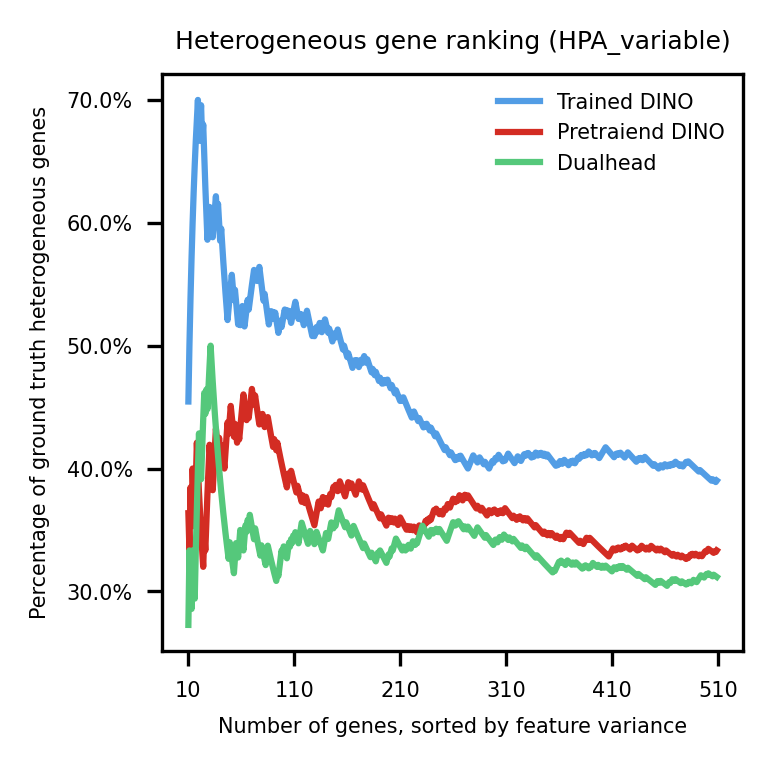

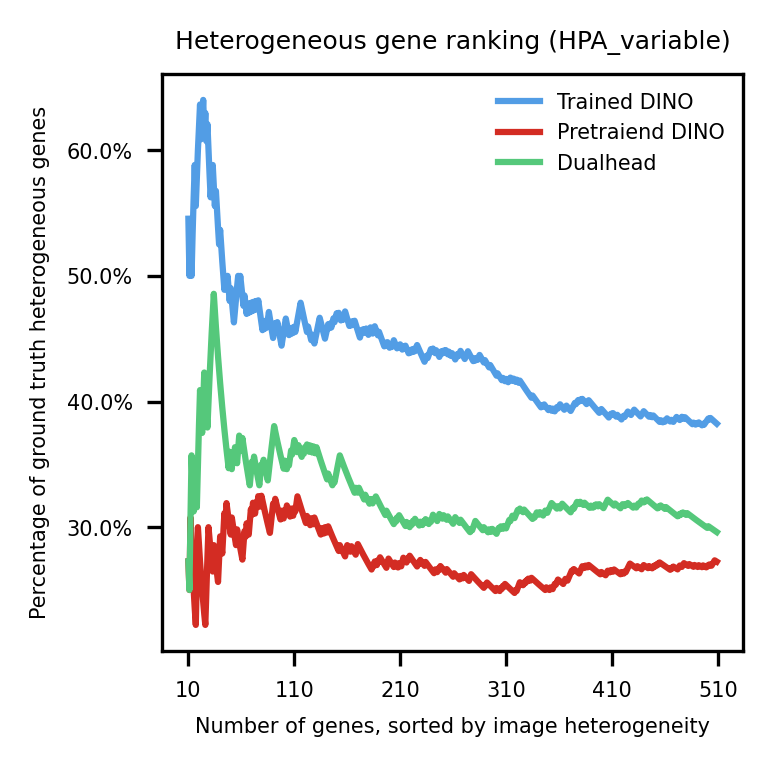

In [10]:
config_files = [
    '/scr/mdoron/Dino4Cells/configs/config_hpa_single_cell_4_channels.yaml',
    '/scr/mdoron/Dino4Cells/configs/config_pretrained.yaml',
    '/scr/mdoron/Dino4Cells/configs/config_tta.yaml',
               ]

labels = [
    'DINO model, single cells',
    'DINO model, trained on ImageNet',
    '2nd place Kaggle competitor',
             ]

condition = 'U-2 OS'

labels = [
    'Trained DINO',
    'Pretraiend DINO',
    'Dualhead',
             ]        
# plot_gene_heterogeneity_enrichement(labels, enrichments_conditioned_on_gene, enrichments_conditioned_on_image, heterogenous_type='HPA_variable')

# enrichments_conditioned_on_gene, enrichments_conditioned_on_image, merged_dfs, genes_sorted_conditioned_on_gene, genes_sorted_conditioned_on_image, sorted_metrics_conditioned_on_gene, sorted_metrics_conditioned_on_image, images_sorted_conditioned_on_image, average_precisions_condition_on_gene, average_precisions_condition_on_image = get_gene_heterogeneity_enrichement(config_files, heterogenous_type='HPA_variable', use_embedding=False, condition=condition)
plot_gene_heterogeneity_enrichement(labels, enrichments_conditioned_on_gene, enrichments_conditioned_on_image, heterogenous_type='HPA_variable')


In [13]:
config_file = '/scr/mdoron/Dino4Cells/configs/config_hpa_single_cell_4_channels.yaml'
feature_type = 'average_umap'
condition = 'U-2 OS'
use_embedding = False
granularity = 'image'
heterogenous_type = 'HPA_variable'

config = yaml.safe_load(open(config_file, "r"))
df = pd.read_csv(config['embedding']['df_path'])    
embedding = pd.read_csv(f"{config['classification']['output_dir']}/{config['classification']['output_prefix']}/embedding_{feature_type}.csv")[['UMAP_1','UMAP_2']].values

heterogeneity_df = get_heterogeneity_df(config_file)
merged_df = pd.merge(heterogeneity_df, df, on='ID', how='right').drop_duplicates()
merged_df.loc[pd.isnull(merged_df['Gene']),'Gene'] = ''
merged_df = merged_df.reset_index()
merged_df['original_index'] = merged_df.index.values
merged_df['cell_type'] = merged_df.cell_type_x
original_indices = merged_df.original_index.values
gene_to_ind = merged_df[['Gene','original_index']].groupby('Gene').groups
gene_to_ind = {k : original_indices[gene_to_ind[k]] for k in gene_to_ind.keys()}
merged_df[pd.isnull(merged_df.Gene)].Gene = ''
features, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    

# protein_localizations = torch.stack(protein_localizations)
if condition == 'U-2 OS':
    features = features[np.where(merged_df.cell_type == 'U-2 OS')[0]]
    embedding = embedding[np.where(merged_df.cell_type == 'U-2 OS')[0]]
    merged_df = merged_df[merged_df.cell_type == 'U-2 OS'].reset_index()
else:
    merged_df = merged_df.reset_index()

if use_embedding:
    umap_reducer, features_mean, features_std, embedding, scaled_features = get_embeddings(torch.Tensor(features), torch.Tensor(features))  
    scaled_features = embedding
else:
    scaled_features, features_mean, features_std = scale(features)
    scaled_features = scaled_features.numpy()

indices = merged_df.index.values
merged_df['original_index'] = merged_df.index.values

if granularity == 'gene':
    mean_stds, sorted_genes = get_heterogeneousity_per_gene(merged_df, scaled_features, indices, metric='std', verbose=False)
elif granularity == 'image':
    mean_stds, sorted_images = get_heterogeneousity_per_whole_image(merged_df, scaled_features, indices, metric='std', verbose=False)

metric = mean_stds
sorted_distances = np.array(metric)[np.argsort(metric)[::-1]]
if granularity == 'gene':
    genes_sorted = np.array(sorted_genes)[np.argsort(metric)[::-1]]
    enrichment_raw = pd.DataFrame(genes_sorted)[0].isin(merged_df[merged_df[heterogenous_type] == True].Gene.unique()).values
    enrichment = []
    for ind in tqdm(range(1, len(genes_sorted), 1)):
        enrichment.append(enrichment_raw[:ind].mean())    
    images_sorted = None
    sorted_distances_per_image = None
    sorted_distances_per_gene = sorted_distances
elif granularity == 'image':
    images_sorted = np.array(sorted_images)[np.argsort(metric)[::-1]]
    merged_df['image_rank'] = merged_df.ID.map(dict(zip(images_sorted, range(len(images_sorted)))))
    merged_df['image_score'] = merged_df.ID.map(dict(zip(images_sorted, sorted_distances)))
    genes_and_image_ranks = merged_df.groupby('Gene')['image_rank'].min()
    genes_and_image_scores = merged_df.groupby('Gene')['image_score'].max()
    genes_ranked_by_images_scores = genes_and_image_scores.values
    genes_ranked_by_images_rank = genes_and_image_ranks.values
    genes_ranked_by_images_names = genes_and_image_ranks.index.values
    genes_sorted = genes_ranked_by_images_names[np.argsort(genes_ranked_by_images_rank)]

    enrichment_raw = pd.DataFrame(genes_sorted)[0].isin(merged_df[merged_df[heterogenous_type] == True].Gene.unique()).values
    enrichment = []
    for ind in tqdm(range(1, len(genes_sorted), 1)):
        enrichment.append(enrichment_raw[:ind].mean())
    sorted_distances_per_image = sorted_distances
    sorted_distances_per_gene = np.array(genes_ranked_by_images_scores)[np.argsort(genes_ranked_by_images_scores)[::-1]]

merged_df = merged_df[['Gene', 'ID', 'v_spatial', 'v_intensity',
       'HPA_variable', 'cell_type_x', 'Unnamed: 0', 'file', 'cell_type_y',
       'actin filaments,focal adhesion sites', 'aggresome',
       'centrosome,centriolar satellite', 'cytosol', 'endoplasmic reticulum',
       'golgi apparatus', 'intermediate filaments', 'microtubules',
       'mitochondria', 'mitotic spindle', 'no staining', 'nuclear bodies',
       'nuclear membrane', 'nuclear speckles', 'nucleoli',
       'nucleoli fibrillar center', 'nucleoplasm',
       'plasma membrane,cell junctions',
       'vesicles,peroxisomes,endosomes,lysosomes,lipid droplets,cytoplasmic bodies',
       'A-431', 'A549', 'AF22', 'ASC TERT1', 'BJ', 'CACO-2', 'EFO-21', 'HAP1',
       'HDLM-2', 'HEK 293', 'HEL', 'HUVEC TERT2', 'HaCaT', 'HeLa', 'Hep G2',
       'JURKAT', 'K-562', 'MCF7', 'PC-3', 'REH', 'RH-30', 'RPTEC TERT1', 'RT4',
       'SH-SY5Y', 'SK-MEL-30', 'SiHa', 'U-2 OS', 'U-251 MG', 'hTCEpi',
       'original_index', 'cell_type', 'image_rank']]    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10567/10567 [00:00<00:00, 133231.56it/s]


In [140]:
config = yaml.safe_load(open(config_file, "r"))
gene2uniprot = pd.read_csv('XML_df/HPA_img_df_new.csv')[['gene','uniport_id']].drop_duplicates()
uniprot2name = pd.read_csv('uniport_interactions.tsv', delimiter='\t')[['Entry','Gene Names']].drop_duplicates()
gene2name = pd.merge(uniprot2name, gene2uniprot, right_on='uniport_id', left_on='Entry')[['gene','Gene Names']]
all_df = merged_df.copy()

# image_rank = list(images_sorted).index('55544_1888_B6_3')
gene_name_1 = 'EFHC2'
gene_name_2 = 'PSTPIP2'
gene_name_3 = 'NUSAP1'
gene_1 = merged_df[merged_df.Gene == gene2name[gene2name['Gene Names'].apply(lambda x:gene_name_1 in str(x))]['gene'].iloc[0]].Gene.iloc[0]
gene_2 = merged_df[merged_df.Gene == gene2name[gene2name['Gene Names'].apply(lambda x:gene_name_2 in str(x))]['gene'].iloc[0]].Gene.iloc[0]
gene_3 = merged_df[merged_df.Gene == gene2name[gene2name['Gene Names'].apply(lambda x:gene_name_3 in str(x))]['gene'].iloc[0]].Gene.iloc[0]
image_rank_1 = merged_df[merged_df.Gene == gene2name[gene2name['Gene Names'].apply(lambda x:gene_name_1 in str(x))]['gene'].iloc[0]].image_rank.iloc[0]
image_rank_2 = merged_df[merged_df.Gene == gene2name[gene2name['Gene Names'].apply(lambda x:gene_name_2 in str(x))]['gene'].iloc[0]].image_rank.iloc[0]
image_rank_3 = merged_df[merged_df.Gene == gene2name[gene2name['Gene Names'].apply(lambda x:gene_name_3 in str(x))]['gene'].iloc[0]].image_rank.iloc[0]
use_well = True
cell_preds = None

gene_1 = merged_df[merged_df.ID == images_sorted[image_rank_1]].Gene.iloc[0]
gene_2 = merged_df[merged_df.ID == images_sorted[image_rank_2]].Gene.iloc[0]
gene_3 = merged_df[merged_df.ID == images_sorted[image_rank_3]].Gene.iloc[0]
gane_name_1 = gene2name[gene2name.gene == gene_1]['Gene Names'].iloc[0].split(' ')[0]
gane_name_2 = gene2name[gene2name.gene == gene_2]['Gene Names'].iloc[0].split(' ')[0]
gane_name_3 = gene2name[gene2name.gene == gene_3]['Gene Names'].iloc[0].split(' ')[0]

if use_well:
    gene_indices_1 = np.where(all_df.ID.apply(lambda x:'_'.join(x.split('_')[:2])) == '_'.join(images_sorted[image_rank_1].split('_')[:2]))[0]
    gene_indices_2 = np.where(all_df.ID.apply(lambda x:'_'.join(x.split('_')[:2])) == '_'.join(images_sorted[image_rank_2].split('_')[:2]))[0]
    gene_indices_3 = np.where(all_df.ID.apply(lambda x:'_'.join(x.split('_')[:2])) == '_'.join(images_sorted[image_rank_3].split('_')[:2]))[0]
else:
    gene_indices_1 = np.where(merged_df.ID == images_sorted[image_rank_1])[0]
    gene_indices_2 = np.where(merged_df.ID == images_sorted[image_rank_2])[0]
    gene_indices_3 = np.where(merged_df.ID == images_sorted[image_rank_3])[0]

all_gene_indices = [
    gene_indices_1,
    gene_indices_2,
    gene_indices_3
]    
gene_df_1 = merged_df.iloc[gene_indices_1].reset_index()
gene_df_2 = merged_df.iloc[gene_indices_2].reset_index()
gene_df_3 = merged_df.iloc[gene_indices_3].reset_index()

targets = torch.Tensor(protein_localizations)
gene_df_1['well'] = gene_df_1.ID
gene_df_2['well'] = gene_df_2.ID
gene_df_3['well'] = gene_df_3.ID
gene_dfs = [gene_df_1, gene_df_2, gene_df_3]
dists_1 = pdist(scaled_features[gene_indices_1], metric='cosine')
dists_2 = pdist(scaled_features[gene_indices_2], metric='cosine')
dists_3 = pdist(scaled_features[gene_indices_3], metric='cosine')
all_dists = [dists_1, dists_2, dists_3]
Z_1 = linkage(dists_1, 'ward')
Z_2 = linkage(dists_2, 'ward')
Z_3 = linkage(dists_3, 'ward')


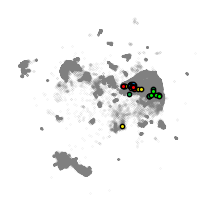

In [110]:

cmap_labels = cm.gist_stern
cmap_image_IDs = cm.nipy_spectral
image_ID_colors = {sorted(np.unique(combined_image_IDs))[i] : cmap_image_IDs(((i + 1) / (len(np.unique(combined_image_IDs)) + 1))) for i in range(len(np.unique(combined_image_IDs)))}
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
plt.scatter(embedding[:,0], 
            embedding[:,1],
            marker='o',
            color='grey',
            alpha=0.5,
           s=0.01)

axis_bounderies = [np.inf, -np.inf, np.inf, -np.inf]
for example_ind, image_IDs in enumerate([image_IDs_1,image_IDs_2,image_IDs_3]):
    for image_ID in sorted(np.unique(image_IDs)):
        indices = np.where(image_IDs == image_ID)[0]
        plt.scatter(embedding[all_gene_indices[example_ind]][indices, 0], 
                    embedding[all_gene_indices[example_ind]][indices, 1],
                    marker='o',
                    color=image_ID_colors[image_ID],
                    edgecolors='black',
                   label=f'Image ID: {image_ID}',
                   s=10)
        axis_bounderies[0] = min(axis_bounderies[0], min(embedding[all_gene_indices[example_ind]][indices, 0]))
        axis_bounderies[1] = max(axis_bounderies[1], max(embedding[all_gene_indices[example_ind]][indices, 0]))
        axis_bounderies[2] = min(axis_bounderies[2], min(embedding[all_gene_indices[example_ind]][indices, 1]))
        axis_bounderies[3] = max(axis_bounderies[3], max(embedding[all_gene_indices[example_ind]][indices, 1]))
   
plt.xticks([])
plt.yticks([])
plt.axis(False)
plt.savefig('figure_5_small_umap.png', transparent=True)


[None, None]

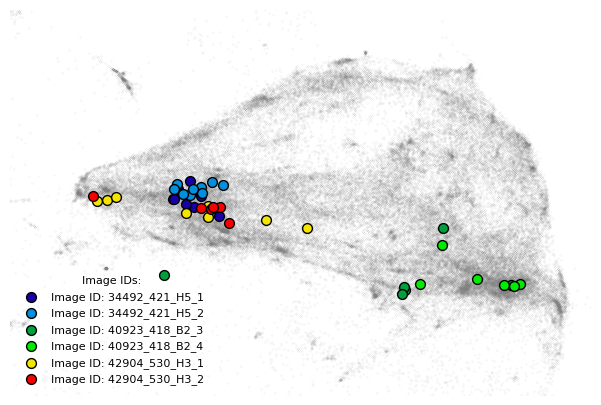

In [153]:

cmap_labels = cm.gist_stern
cmap_image_IDs = cm.nipy_spectral
image_ID_colors = {sorted(np.unique(combined_image_IDs))[i] : cmap_image_IDs(((i + 1) / (len(np.unique(combined_image_IDs)) + 1))) for i in range(len(np.unique(combined_image_IDs)))}
fig, ax = plt.subplots(1,1,figsize=(2.5 * 3,2.5 * 2))
plt.scatter(embedding[:,0], 
            embedding[:,1],
            marker='o',
            color='grey',
            alpha=0.5,
           s=0.01)

axis_bounderies = [np.inf, -np.inf, np.inf, -np.inf]
for example_ind, image_IDs in enumerate([image_IDs_1,image_IDs_2,image_IDs_3]):
    for image_ID in sorted(np.unique(image_IDs)):
        indices = np.where(image_IDs == image_ID)[0]
        plt.scatter(embedding[all_gene_indices[example_ind]][indices, 0], 
                    embedding[all_gene_indices[example_ind]][indices, 1],
                    marker='o',
                    color=image_ID_colors[image_ID],
                    edgecolors='black',
                   label=f'Image ID: {image_ID}',
                   s=50)
        axis_bounderies[0] = min(axis_bounderies[0], min(embedding[all_gene_indices[example_ind]][indices, 0]))
        axis_bounderies[1] = max(axis_bounderies[1], max(embedding[all_gene_indices[example_ind]][indices, 0]))
        axis_bounderies[2] = min(axis_bounderies[2], min(embedding[all_gene_indices[example_ind]][indices, 1]))
        axis_bounderies[3] = max(axis_bounderies[3], max(embedding[all_gene_indices[example_ind]][indices, 1]))

axis_bounderies[0] -= 3
axis_bounderies[1] += 3
axis_bounderies[2] += 10
axis_bounderies[3] += 10
plt.xticks([])
plt.yticks([])
plt.axis(axis_bounderies)
plt.axis(False)

legend = plt.legend(frameon=False, fontsize=8, title='Image IDs:')
plt.setp(legend.get_title(),fontsize=8)



In [183]:
lut1

{'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]': (0.4519420198186802,
  0.16470588235294117,
  0.32941176470588235,
  1.0),
 '[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]': (0.3333333333333333,
  0.3333333333333333,
  0.6666666666666666,
  1.0),
 '[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]': (0.5019607843137255,
  0.5019607843137255,
  0.9916562369628703,
  1.0),
 '[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]': (0.6666666666666667,
  0.6666666666666666,
  0.2907801418439714,
  1.0)}

[None, None]

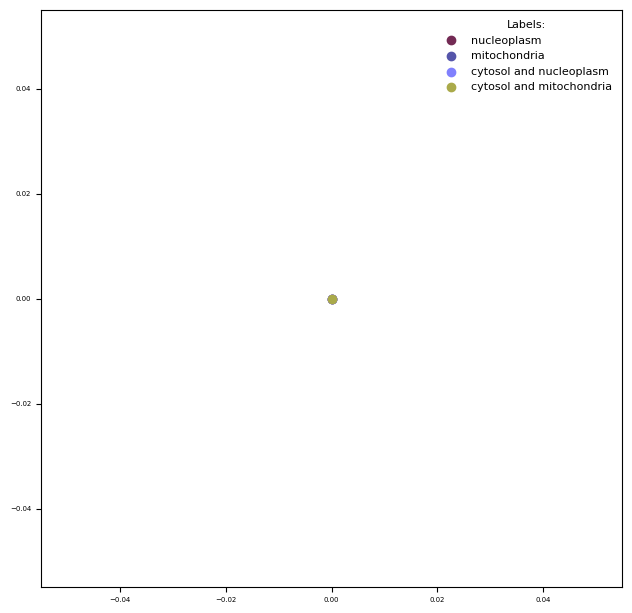

In [190]:
sorted_protein_labels = np.array(sorted(protein_to_num_single_cells.keys()))
labels = []
plt.figure(figsize=(2.5 * 3, 2.5 * 3))
for key in list(lut1.keys()):
    plt.scatter([0],[0], label=' and '.join(sorted_protein_labels[np.where(eval(key))[0]]), color=lut1[key])

legend = plt.legend(frameon=False, fontsize=8, title='Labels:')
plt.setp(legend.get_title(),fontsize=8)



/scr/mdoron/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/scr/mdoron/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/scr/mdoron/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 640x480 with 0 Axes>

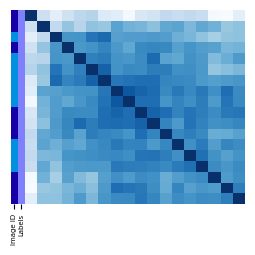

<Figure size 640x480 with 0 Axes>

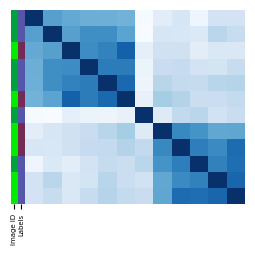

<Figure size 640x480 with 0 Axes>

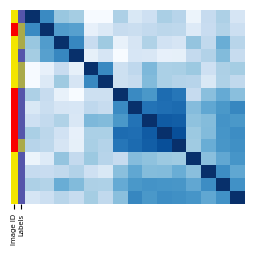

In [146]:

all_example_targets = ((targets[np.concatenate(all_gene_indices)]).numpy()).astype(int)
all_c2 = [str(list(i)) for i in all_example_targets]
lut1 = dict(zip(np.unique(all_c2), [cmap_labels((i + 1) / (2 + len(np.unique(all_c2)))) for i in range(len(np.unique(all_c2)))]))

for example_ind, gene_indices in enumerate(all_gene_indices):
    row_colors1 = gene_dfs[example_ind]['ID'].map(image_ID_colors)
    row_colors1.name = 'Image ID'
    b = ((targets[gene_indices]).numpy()).astype(int)
    c2 = [str(list(i)) for i in b]
    series = pd.DataFrame(c2)[0]
    series.name = 'Labels'
    row_colors3 = series.map(lut1)
    row_colors = pd.concat([row_colors1,row_colors3],axis=1)

    if cell_preds is not None:
        b = ((cell_preds[gene_indices])).astype(int)
        c1 = [str(list(i)) for i in b]
        series = pd.DataFrame(c1)[0]
        series.name = 'Prediction'
        lut1 = dict(zip(np.unique(c1), [cmap_labels(i / len(np.unique(c1))) for i in range(len(np.unique(c1)))]))
        row_colors2 = series.map(lut1)
        row_colors = pd.concat([row_colors1,row_colors2,row_colors3],axis=1)
    
    plt.figure()
    c = clustermap(pd.DataFrame(squareform(all_dists[example_ind])),
                   figsize=(2.5, 2.5),
                   cbar_pos=None, 
                   xticklabels=[], 
                   yticklabels=[], 
                   cmap='Blues_r', 
                   dendrogram_ratio=[0,0],
                   col_cluster=True,
                   row_cluster=True,
                   row_colors = row_colors,
                   cbar_kws={"size": 20},
                   facecolor='white'
    )

#     c = clustermap(pd.DataFrame(squareform(all_dists[example_ind])),
#                    figsize=(2.5,2.5),
#                    cbar_pos=None, 
#                    xticklabels=[], 
#                    yticklabels=gene_dfs[example_ind].file.apply(lambda x:x.split('/')[-1]).values, 
#                    cmap='Blues_r', 
#                    dendrogram_ratio=[0,0],
#                    col_cluster=True,
#                    row_cluster=True,
#                    row_colors = row_colors,
#                    cbar_kws={"size": 20},
#                    facecolor='white'
#     )
#     num_to_protein = {ind : k for ind, k in enumerate(sorted(protein_to_num_single_cells.keys()))}

#     for ID in gene_df.ID.unique():
#         gene_type = 'heterogeneous' if merged_df[merged_df.ID == ID].HPA_variable.iloc[0] == True else 'unlabeled'
#         img = io.imread(f'/scr/mdoron/Dino4Cells/data/whole_images/{ID}.png')
#         fig, axes = plt.subplots(1,2,figsize=(10,5))
#         axes[0].imshow(img[:,:,[0,2,3]])
#         axes[0].axis(False)
#         axes[1].imshow(img[:,:,[1]], cmap='Greys_r')
#         axes[1].axis(False)
#         axes[0].set_title('Non protein channels')
#         axes[1].set_title('Protein channel')
#         plt.tight_layout()

#     # for f in gene_df.file.values:
#     fig, axes = plt.subplots(len(gene_dfs[example_ind]),1, figsize=(1, len(c.fig.get_axes()[3].get_yticklabels())))
#     for ind, f in enumerate([i._text for i in c.fig.get_axes()[3].get_yticklabels()]):    
#     #     gene_type = 'heterogeneous' if merged_df[merged_df.ID == ID].HPA_variable.iloc[0] == True else 'unlabeled'
# #         print(f.split('/')[-1])
#         img = io.imread(f'/scr/mdoron/Dino4Cells/data/fixed_size_masked_single_cells_HPA/{f}')
#         axes[ind].imshow(img[:,:,[1]], cmap='Greys_r')
#         axes[ind].axis(False)
